# Make Figures for Model Validation: Cycles, Storage, Cycles

5/9/2023

Andrew Weng

In [1]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%load_ext autoreload


# Load the Experimental Data

In [2]:
plotter.initialize(plt, style='default')

target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'

# To make the dQ/dV plot work, be sure to only select the FORM protocol without
# including the aging file. Otherwise the time vector will be confused.
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 80

elif cellid == 152074: # BASELINE FORMATION (repeat 2)

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 80

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_79637/814279506.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


# Run the simulation

In [3]:
%autoreload
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/default.yaml')
tag = cell.get_tag()

sim = cellsim.Simulation(cell, 125*3600)
# sim = cellsim.Simulation(cell, 70*3600)

# Formation
sim.run_chg_cccv(1, Ichg, Icv, vmax)
sim.run_rest(1, rest_time_hrs=40)
sim.run_dch_cccv(1, Idch, Idch, vmin)
sim.run_chg_cccv(2, Ichg, Icv, vmax)
sim.run_rest(2, rest_time_hrs=40)
# sim.run_dch_cccv(2, Idch, Idch, 3.5)
# sim.run_rest(2, rest_time_hrs=30)

df_sim = sim.get_results()


Running Cyc1: Charge to 4.2V...
Running Cyc1: Rest for 40 hours...
Running Cyc1: Discharge to 3.0V...
Running Cyc2: Charge to 4.2V...
Running Cyc2: Rest for 40 hours...


/Users/aweng/code/formation-modeling/src/cellsim.py:752: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/fig_timeseries_3.tif',
/Users/aweng/code/formation-modeling/src/cellsim.py:900: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'outputs/figures/{fig_name}.png',
/Users/aweng/code/formation-modeling/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


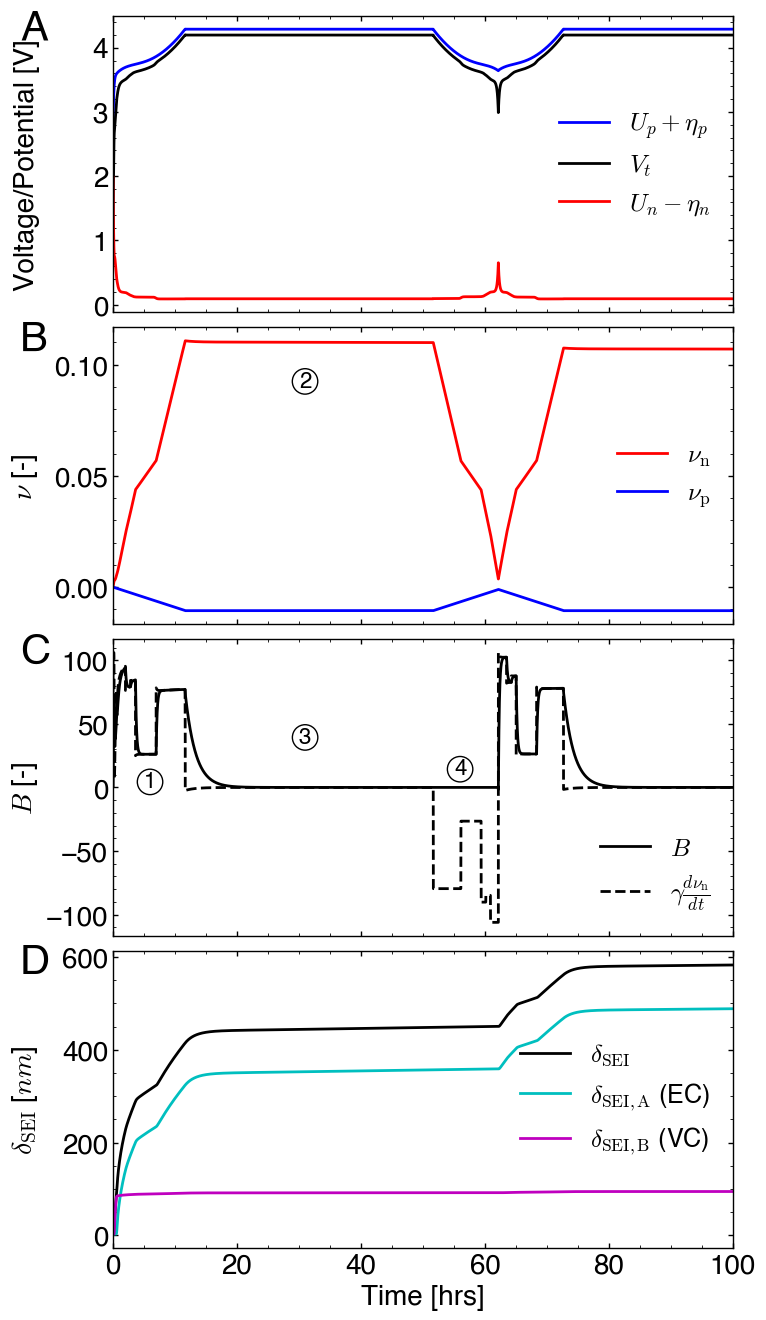

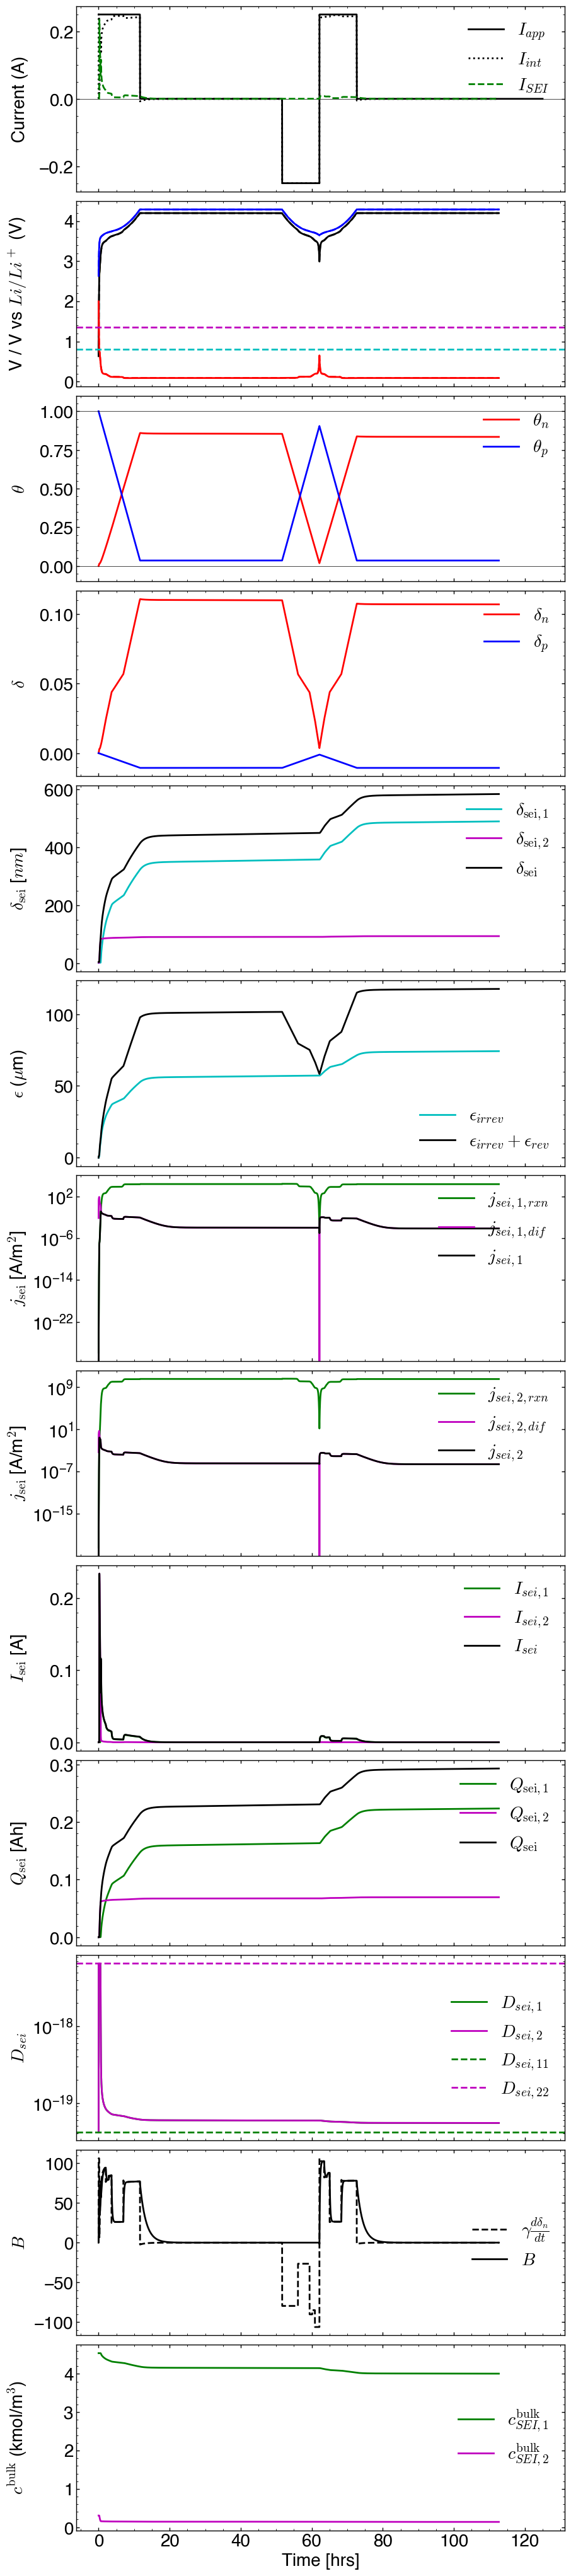

In [4]:
# %matplotlib widget
%autoreload
sim.plot_view_3(xlims=(0,100))
sim.plot()
